In [ ]:
#Reading the training data Subject
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing all needed libraries
import pandas as pd
import numpy as np #Matric math
import tensorflow as tf #ML
from tensorflow.python.framework import ops
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import sys
import os
from scipy.io import loadmat
from scipy.io import loadmat





### **Dataset Loading**

In [ ]:
NUM_EMG_CHANNELS = 12
FEATURES_PER_CHANNEL = 8
TOTAL_FEATURES = NUM_EMG_CHANNELS * FEATURES_PER_CHANNEL
SEQ_LENGTH = 25
DOF_COUNT = 22
VAL_SUBJECTS = 3
MAML_INNER_STEPS = 5
MAML_META_LR = 0.001
MAML_INNER_LR = 0.01
MAML_BATCH_SIZE = 20

# ===================== ROBUST LOSS FUNCTION =====================
def hybrid_loss(y_true, y_pred):
    """Dtype-consistent loss implementation"""
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    mse = tf.keras.losses.MeanSquaredError()(y_true, y_pred)

    y_true_mean = tf.reduce_mean(y_true, axis=0)
    y_pred_mean = tf.reduce_mean(y_pred, axis=0)
    covariance = tf.reduce_mean((y_true - y_true_mean) * (y_pred - y_pred_mean))
    std_product = tf.math.reduce_std(y_true) * tf.math.reduce_std(y_pred)
    pearson = covariance / (std_product + 1e-8)

    return 0.6 * mse + 0.4 * (1 - pearson)

# ===================== DATA LOADER WITH VALIDATION =====================
class EMGDataset:
    def __init__(self, base_path, subjects):
        self.base_path = base_path
        self.subjects = subjects
        self.scaler = StandardScaler()

    def _load_subject(self, subject):
        data = loadmat(f"{self.base_path}/S{subject}_E1.mat")["Data"]
        features = data[:, :TOTAL_FEATURES]
        labels = data[:, TOTAL_FEATURES:TOTAL_FEATURES+DOF_COUNT]
        return features, labels

    # def _create_sequences(self, data, labels):
    #     sequences = []
    #     targets = []
    #     for i in range(len(data) - SEQ_LENGTH + 1):
    #         sequences.append(data[i:i+SEQ_LENGTH])
    #         targets.append(labels[i+SEQ_LENGTH-1])
    #     return (
    #         np.array(sequences, dtype=np.float32),
    #         np.array(targets, dtype=np.float32)
    #     )
    def _create_sequences(self, data, labels):
      sequences = []
      targets = []
    # Use smaller step size
      step_size = 1  # Instead of SEQ_LENGTH
      for i in range(0, len(data) - SEQ_LENGTH + 1, step_size):
        sequences.append(data[i:i+SEQ_LENGTH])
        targets.append(labels[i+SEQ_LENGTH-1])
      return np.array(sequences), np.array(targets)

    def load_data(self, test_subject):
        full_data = {}
        all_features = []

        # First pass to collect all features
        for s in self.subjects:
            f, _ = self._load_subject(s)
            all_features.append(f)

        # Identify validation subjects
        train_subjects = [s for s in self.subjects if s != test_subject]
        val_subjects = np.random.choice(train_subjects, VAL_SUBJECTS, replace=False)
        train_subjects = [s for s in train_subjects if s not in val_subjects]

        # Fit scaler on training subjects only
        train_features = np.concatenate([f for s,f in zip(self.subjects, all_features)
                                       if s in train_subjects])
        self.scaler.fit(train_features)

        # Process all subjects
        for s in self.subjects:
            f, l = self._load_subject(s)
            f_scaled = self.scaler.transform(f)
            seq, lab = self._create_sequences(f_scaled, l)
            full_data[s] = (seq.astype(np.float32), lab.astype(np.float32))

        return full_data, train_subjects, val_subjects

### **MAML**

In [ ]:
import tensorflow as tf
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, Model, Input

class MAMLModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # Explicit dtype specification for all layers
        self.conv = layers.Conv1D(32, 3, padding='same', activation='relu', dtype=tf.float32)
        self.lstm1 = layers.Bidirectional(
            layers.LSTM(64, return_sequences=True, dtype=tf.float32),
            dtype=tf.float32
        )
        self.lstm2 = layers.Bidirectional(
            layers.LSTM(32, dtype=tf.float32),
            dtype=tf.float32
        )
        self.dense = layers.Dense(128, activation='relu', dtype=tf.float32)
        self.dropout = layers.Dropout(0.2, dtype=tf.float32)
        self.heads = [layers.Dense(1, dtype=tf.float32) for _ in range(DOF_COUNT)]

        # Build with concrete tensor
        self(tf.zeros([1, SEQ_LENGTH, TOTAL_FEATURES], dtype=tf.float32))

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        x = self.conv(inputs)
        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.dense(x)
        x = self.dropout(x)
        return tf.concat([head(x) for head in self.heads], axis=-1)

    def clone(self):
        clone = MAMLModel()
        clone.set_weights(self.get_weights())
        return clone
# ===================== OPTIMIZER-AWARE TRAINER =====================
class MAMLTrainer:
    def __init__(self, model):
        self.model = model
        # Use native Python float for learning rate
        self.meta_optimizer = tf.keras.optimizers.Adam(learning_rate=MAML_META_LR)
        self.loss_fn = hybrid_loss

        # Initialize model with proper dtype
        dummy_input = tf.zeros([1, SEQ_LENGTH, TOTAL_FEATURES], dtype=tf.float32)
        _ = self.model(dummy_input)

    def inner_update(self, model, support_data):
        support_x, support_y = support_data
        support_x = tf.cast(support_x, tf.float32)
        support_y = tf.cast(support_y, tf.float32)

        with tf.GradientTape() as tape:
            pred = model(support_x, training=True)
            loss = self.loss_fn(support_y, pred)

        grads = tape.gradient(loss, model.trainable_variables)
        lr = tf.cast(MAML_INNER_LR, tf.float32)
        for var, grad in zip(model.trainable_variables, grads):
            if grad is not None:
                var.assign_sub(lr * tf.cast(grad, var.dtype))
        return loss.numpy()

    def meta_step(self, tasks):
      if not tasks:
        return

      meta_grads = []
      for task in tasks:
        clone = self.model.clone()
        (s_x, s_y), (q_x, q_y) = task

        # Skip invalid tasks
        if len(s_x) == 0 or len(q_x) == 0:
            continue

        # Inner loop adaptation
        for _ in range(MAML_INNER_STEPS):
            self.inner_update(clone, (s_x, s_y))

        # Query evaluation
        with tf.GradientTape() as tape:
            q_pred = clone(q_x, training=True)
            q_loss = self.loss_fn(q_y, q_pred)

        # Get gradients relative to original model variables
        grads = tape.gradient(q_loss, clone.trainable_variables)
        meta_grads.append(grads)

    # Average and apply gradients (FIXED SYNTAX)
      if meta_grads:
        avg_grads = [
            tf.reduce_mean(
                tf.stack([g[i] for g in meta_grads if g[i] is not None]),
                axis=0
            )
            for i in range(len(meta_grads[0]))
        ]
        valid_grads = [g for g in avg_grads if g is not None]
        valid_vars = [var for var, g in zip(self.model.trainable_variables, avg_grads) if g is not None]
        self.meta_optimizer.apply_gradients(zip(valid_grads, valid_vars))

### **Loading Dataset**

In [ ]:
# ===================== DATA HANDLING =====================
class MAMLDataset(EMGDataset):
    def prepare_tasks(self, test_subject):
        tasks = []
        train_subjects = [s for s in self.subjects if s != test_subject]

        # Fit scaler only on training subjects
        train_features = np.concatenate([self._load_subject(s)[0] for s in train_subjects])
        self.scaler.fit(train_features)

        for s in self.subjects:
            if s == test_subject:
                continue

            X, y = self._load_subject(s)
            X = self.scaler.transform(X)
            seq, lab = self._create_sequences(X, y)

            if len(seq) >= 20:
                split = int(0.8 * len(seq))
                tasks.append(((seq[:split], lab[:split]), (seq[split:], lab[split:])))
        return tasks

    def load_test_subject(self, test_subject):
        X, y = self._load_subject(test_subject)
        X = self.scaler.transform(X)
        return self._create_sequences(X, y)

### **Saving the result**

In [ ]:
# Save data in Excel file
def savedata(i, correlations):
    """
    Save the correlations data in an Excel file at the specified row.

    Parameters:
    - i: Integer representing the subject number (e.g., 5 for row name 'S5').
    - correlations: List of correlation values to save in the row.
    """
    import openpyxl
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive')

    # Path to the workbook
    workbook_path = '/content/drive/My Drive/Colab Notebooks/dataset/Ninapro Anatomical model+MAML-Subject Independant.xlsx'

    # Load the existing workbook
    wb = openpyxl.load_workbook(workbook_path)

    # Select the active sheet
    sheet = wb.active

    # Dynamically set the row name based on 'i'
    row_name = f'S{i}'  # Example: 'S5' if i=5

    # Find the row with the specified row name
    target_row = None
    for row in sheet.iter_rows(min_row=1, max_row=sheet.max_row):
        if row[0].value == row_name:
            target_row = row[0].row
            break

    if target_row is None:
        print(f"Error: Row with name '{row_name}' not found in the sheet.")
        return

    # Write the data to the found row, starting from the second column
    for col, value in enumerate(correlations, start=2):  # Start at column 2 to skip the first column for the label
        sheet.cell(row=target_row, column=col, value=value)

    # Save the workbook
    wb.save(workbook_path)
    print(f"Data successfully saved for row '{row_name}'.")


### **Evaluation**

In [ ]:

# ===================== EVALUATION GUARANTEES =====================
def evaluate_on_val(tasks):
    """Evaluate on held-out validation subjects"""
    val_losses = []
    for task in tasks[:VAL_SUBJECTS]:  # First N as validation
        _, (q_x, q_y) = task
        pred = model(q_x)
        val_losses.append(tf.reduce_mean(hybrid_loss(q_y, pred)))
    return np.mean(val_losses)

def load_test_subject(self, test_subject):
    """Isolated test data loading"""
    f, l = self._load_subject(test_subject)
    f = self.scaler.transform(f)  # Use fitted scaler
    return self._create_sequences(f, l)

In [ ]:
# --------------------- EVALUATION ---------------------
class DOFEvaluator:
    def __init__(self):
        self.metrics = {
            'pearson': np.zeros(DOF_COUNT),
            'rmse': np.zeros(DOF_COUNT),
            'count': 0
        }

    def update_metrics(self, y_true, y_pred):
        for i in range(DOF_COUNT):
            r_val, _ = pearsonr(y_true[:, i], y_pred[:, i])
            self.metrics['pearson'][i] += r_val
            self.metrics['rmse'][i] += np.sqrt(np.mean((y_true[:, i]-y_pred[:, i])**2))
        self.metrics['count'] += 1

    def plot_results(self):
        avg_pearson = self.metrics['pearson'] / self.metrics['count']

        plt.figure(figsize=(15, 6))
        plt.bar(range(DOF_COUNT), avg_pearson)
        plt.xticks(range(DOF_COUNT), [f'DOF{i}' for i in range(DOF_COUNT)], rotation=90)
        plt.axhline(0.6, color='red', linestyle='--')
        plt.title('Average Pearson Correlation per DOF')
        plt.ylabel('Correlation')
        plt.ylim(-0.5, 1.0)
        plt.show()

### **Main**


=== Testing Subject 5 ===
Epoch 0, Validation Loss: 0.5403
Epoch 1, Validation Loss: 0.5068
Epoch 2, Validation Loss: 0.4778
Epoch 3, Validation Loss: 0.4492
Epoch 4, Validation Loss: 0.4201
Epoch 5, Validation Loss: 0.3917
Epoch 6, Validation Loss: 0.3670
Epoch 7, Validation Loss: 0.3463
Epoch 8, Validation Loss: 0.3283
Epoch 9, Validation Loss: 0.3126
Epoch 10, Validation Loss: 0.2987
Epoch 11, Validation Loss: 0.2873
Epoch 12, Validation Loss: 0.2781
Epoch 13, Validation Loss: 0.2710
Epoch 14, Validation Loss: 0.2652
Epoch 15, Validation Loss: 0.2598
Epoch 16, Validation Loss: 0.2523
Epoch 17, Validation Loss: 0.2444
Epoch 18, Validation Loss: 0.2383
Epoch 19, Validation Loss: 0.2324
Epoch 20, Validation Loss: 0.2275
Epoch 21, Validation Loss: 0.2236
Epoch 22, Validation Loss: 0.2225
Epoch 23, Validation Loss: 0.2228
Epoch 24, Validation Loss: 0.2219
Epoch 25, Validation Loss: 0.2179
Epoch 26, Validation Loss: 0.2131
Epoch 27, Validation Loss: 0.2114
Epoch 28, Validation Loss: 0.21

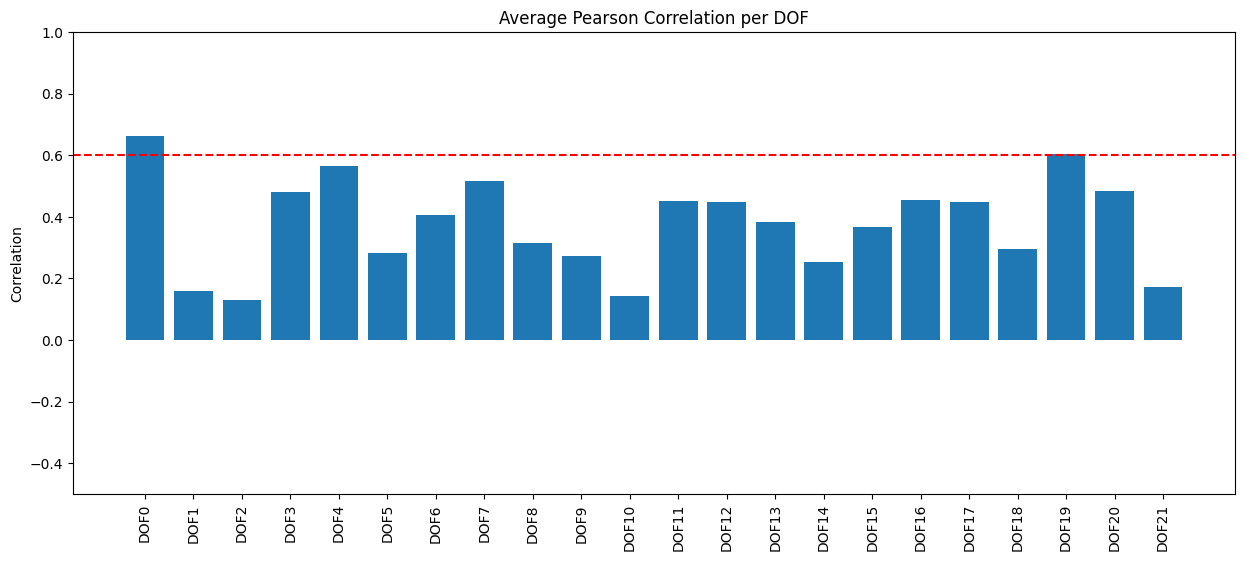


=== Testing Subject 6 ===
Epoch 0, Validation Loss: 0.1885
Epoch 1, Validation Loss: 0.1873
Epoch 2, Validation Loss: 0.1869
Epoch 3, Validation Loss: 0.1870
Epoch 4, Validation Loss: 0.1875
Epoch 5, Validation Loss: 0.1886
Epoch 6, Validation Loss: 0.1889
Epoch 7, Validation Loss: 0.1884
Epoch 8, Validation Loss: 0.1883
Epoch 9, Validation Loss: 0.1886
Epoch 10, Validation Loss: 0.1894
Epoch 11, Validation Loss: 0.1901
Epoch 12, Validation Loss: 0.1900
Epoch 13, Validation Loss: 0.1898
Epoch 14, Validation Loss: 0.1896
Epoch 15, Validation Loss: 0.1895
Epoch 16, Validation Loss: 0.1895
Epoch 17, Validation Loss: 0.1901
Epoch 18, Validation Loss: 0.1915
Epoch 19, Validation Loss: 0.1920
Epoch 20, Validation Loss: 0.1918
Epoch 21, Validation Loss: 0.1915
Epoch 22, Validation Loss: 0.1913
Epoch 23, Validation Loss: 0.1917
Epoch 24, Validation Loss: 0.1901
Epoch 25, Validation Loss: 0.1892
Epoch 26, Validation Loss: 0.1888
Epoch 27, Validation Loss: 0.1894
Epoch 28, Validation Loss: 0.18

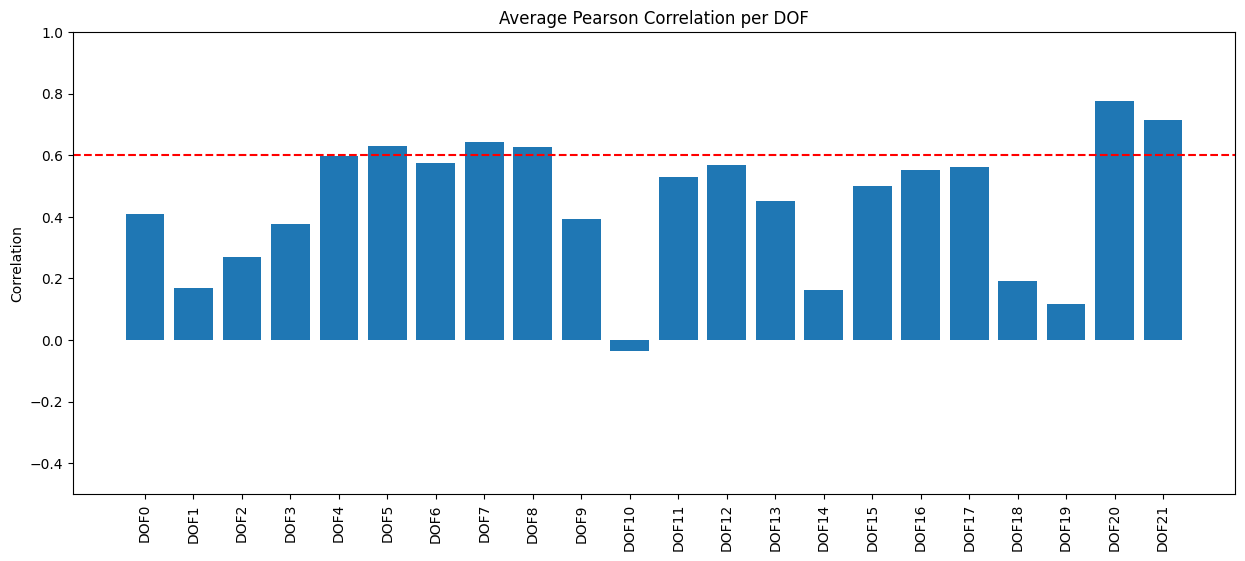


=== Testing Subject 7 ===
Epoch 0, Validation Loss: 0.1835
Epoch 1, Validation Loss: 0.1816
Epoch 2, Validation Loss: 0.1798
Epoch 3, Validation Loss: 0.1782
Epoch 4, Validation Loss: 0.1768
Epoch 5, Validation Loss: 0.1760
Epoch 6, Validation Loss: 0.1776
Epoch 7, Validation Loss: 0.1791
Epoch 8, Validation Loss: 0.1802
Epoch 9, Validation Loss: 0.1809
Epoch 10, Validation Loss: 0.1819
Epoch 11, Validation Loss: 0.1830
Epoch 12, Validation Loss: 0.1818
Epoch 13, Validation Loss: 0.1808
Epoch 14, Validation Loss: 0.1811
Epoch 15, Validation Loss: 0.1812
Epoch 16, Validation Loss: 0.1796
Epoch 17, Validation Loss: 0.1778
Epoch 18, Validation Loss: 0.1771
Epoch 19, Validation Loss: 0.1778
Epoch 20, Validation Loss: 0.1779
Epoch 21, Validation Loss: 0.1779
Epoch 22, Validation Loss: 0.1779
Epoch 23, Validation Loss: 0.1788
Epoch 24, Validation Loss: 0.1800
Epoch 25, Validation Loss: 0.1810
Epoch 26, Validation Loss: 0.1806
Epoch 27, Validation Loss: 0.1788
Epoch 28, Validation Loss: 0.17

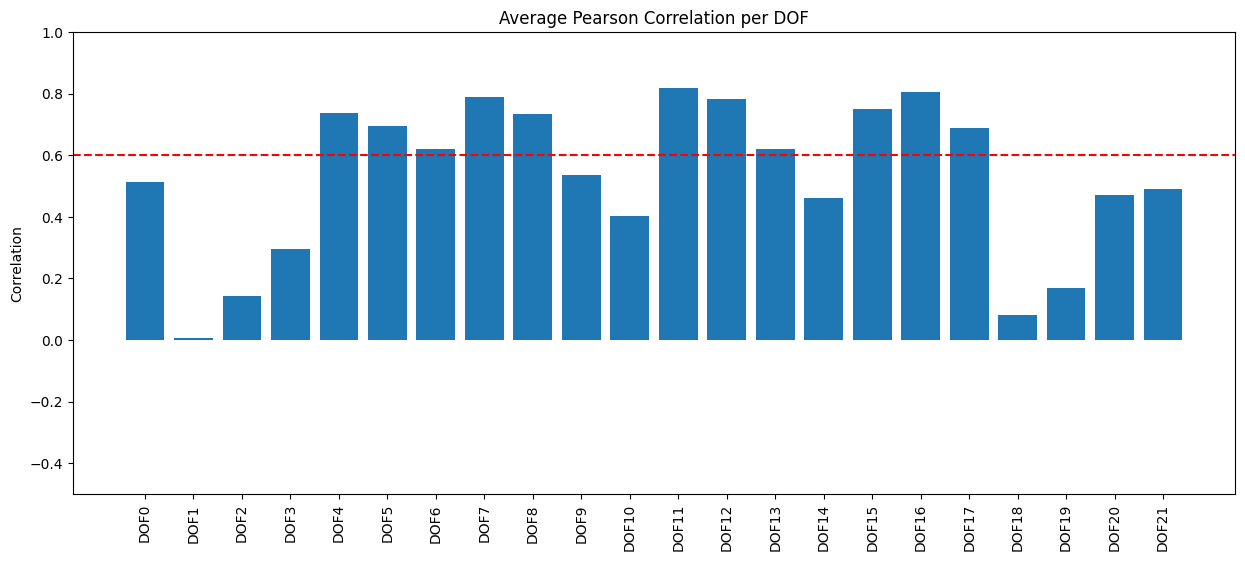


=== Testing Subject 8 ===
Epoch 0, Validation Loss: 0.1768
Epoch 1, Validation Loss: 0.1767
Epoch 2, Validation Loss: 0.1770
Epoch 3, Validation Loss: 0.1748
Epoch 4, Validation Loss: 0.1735
Epoch 5, Validation Loss: 0.1714
Epoch 6, Validation Loss: 0.1730
Epoch 7, Validation Loss: 0.1746
Epoch 8, Validation Loss: 0.1764
Epoch 9, Validation Loss: 0.1771
Epoch 10, Validation Loss: 0.1775
Epoch 11, Validation Loss: 0.1765
Epoch 12, Validation Loss: 0.1757
Epoch 13, Validation Loss: 0.1756
Epoch 14, Validation Loss: 0.1767
Epoch 15, Validation Loss: 0.1773
Epoch 16, Validation Loss: 0.1776
Epoch 17, Validation Loss: 0.1784
Epoch 18, Validation Loss: 0.1786
Epoch 19, Validation Loss: 0.1775
Epoch 20, Validation Loss: 0.1755
Epoch 21, Validation Loss: 0.1748
Epoch 22, Validation Loss: 0.1746
Epoch 23, Validation Loss: 0.1753
Epoch 24, Validation Loss: 0.1758
Epoch 25, Validation Loss: 0.1760
Epoch 26, Validation Loss: 0.1768
Epoch 27, Validation Loss: 0.1775
Epoch 28, Validation Loss: 0.17

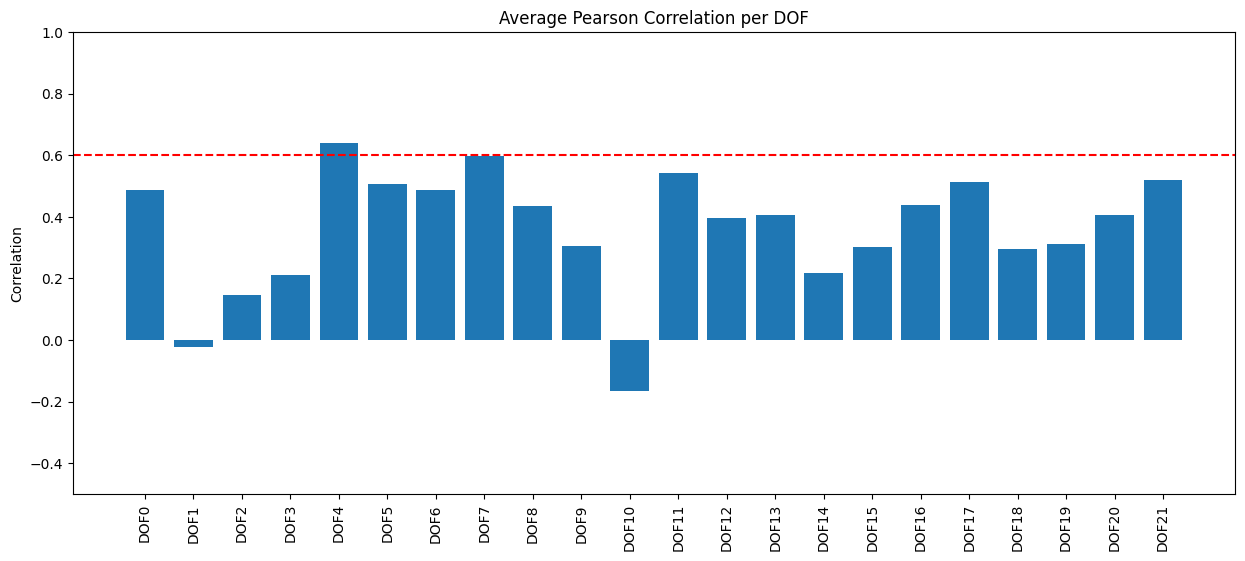


=== Testing Subject 9 ===
Epoch 0, Validation Loss: 0.1749
Epoch 1, Validation Loss: 0.1744
Epoch 2, Validation Loss: 0.1735
Epoch 3, Validation Loss: 0.1727
Epoch 4, Validation Loss: 0.1734
Epoch 5, Validation Loss: 0.1747
Epoch 6, Validation Loss: 0.1769
Epoch 7, Validation Loss: 0.1780
Epoch 8, Validation Loss: 0.1744
Epoch 9, Validation Loss: 0.1720
Epoch 10, Validation Loss: 0.1723
Epoch 11, Validation Loss: 0.1721
Epoch 12, Validation Loss: 0.1734
Epoch 13, Validation Loss: 0.1750
Epoch 14, Validation Loss: 0.1770
Epoch 15, Validation Loss: 0.1720
Epoch 16, Validation Loss: 0.1688
Epoch 17, Validation Loss: 0.1676
Epoch 18, Validation Loss: 0.1678
Epoch 19, Validation Loss: 0.1690
Epoch 20, Validation Loss: 0.1706
Epoch 21, Validation Loss: 0.1722
Epoch 22, Validation Loss: 0.1723
Epoch 23, Validation Loss: 0.1704
Epoch 24, Validation Loss: 0.1686
Epoch 25, Validation Loss: 0.1681
Epoch 26, Validation Loss: 0.1692
Epoch 27, Validation Loss: 0.1695
Epoch 28, Validation Loss: 0.17

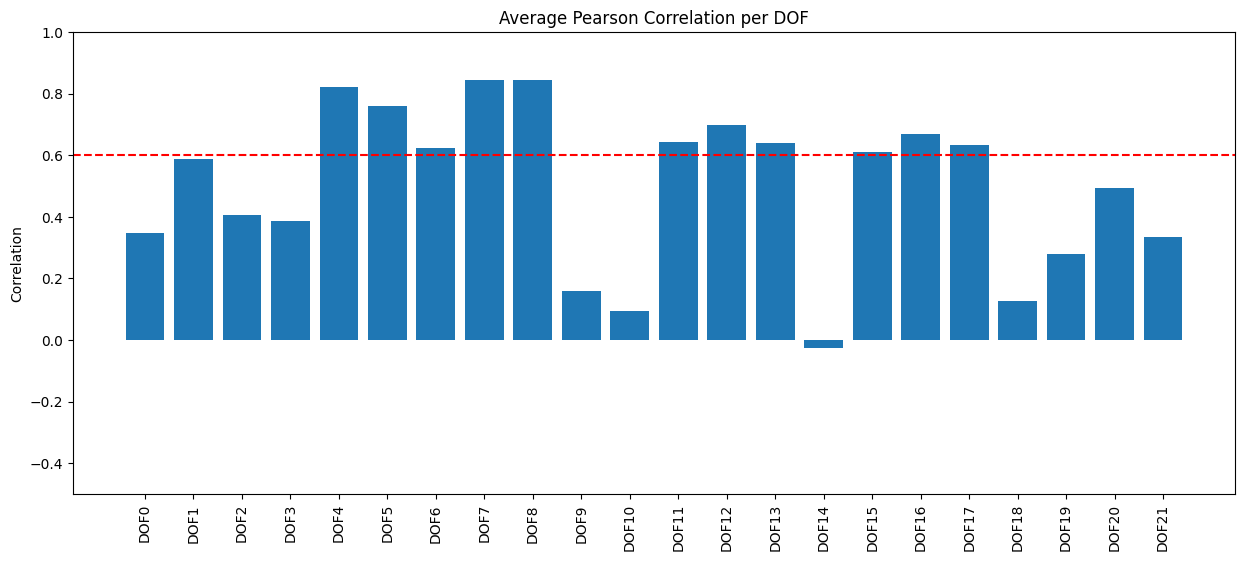


=== Testing Subject 10 ===
Epoch 0, Validation Loss: 0.1702
Epoch 1, Validation Loss: 0.1682
Epoch 2, Validation Loss: 0.1675
Epoch 3, Validation Loss: 0.1675
Epoch 4, Validation Loss: 0.1675
Epoch 5, Validation Loss: 0.1675
Epoch 6, Validation Loss: 0.1673
Epoch 7, Validation Loss: 0.1667
Epoch 8, Validation Loss: 0.1666
Epoch 9, Validation Loss: 0.1692
Epoch 10, Validation Loss: 0.1704
Epoch 11, Validation Loss: 0.1717
Epoch 12, Validation Loss: 0.1728
Epoch 13, Validation Loss: 0.1688
Epoch 14, Validation Loss: 0.1667
Epoch 15, Validation Loss: 0.1674
Epoch 16, Validation Loss: 0.1689
Epoch 17, Validation Loss: 0.1691
Epoch 18, Validation Loss: 0.1696
Epoch 19, Validation Loss: 0.1695
Epoch 20, Validation Loss: 0.1685
Epoch 21, Validation Loss: 0.1673
Epoch 22, Validation Loss: 0.1679
Epoch 23, Validation Loss: 0.1690
Epoch 24, Validation Loss: 0.1691
Epoch 25, Validation Loss: 0.1696
Epoch 26, Validation Loss: 0.1695
Epoch 27, Validation Loss: 0.1696
Epoch 28, Validation Loss: 0.1

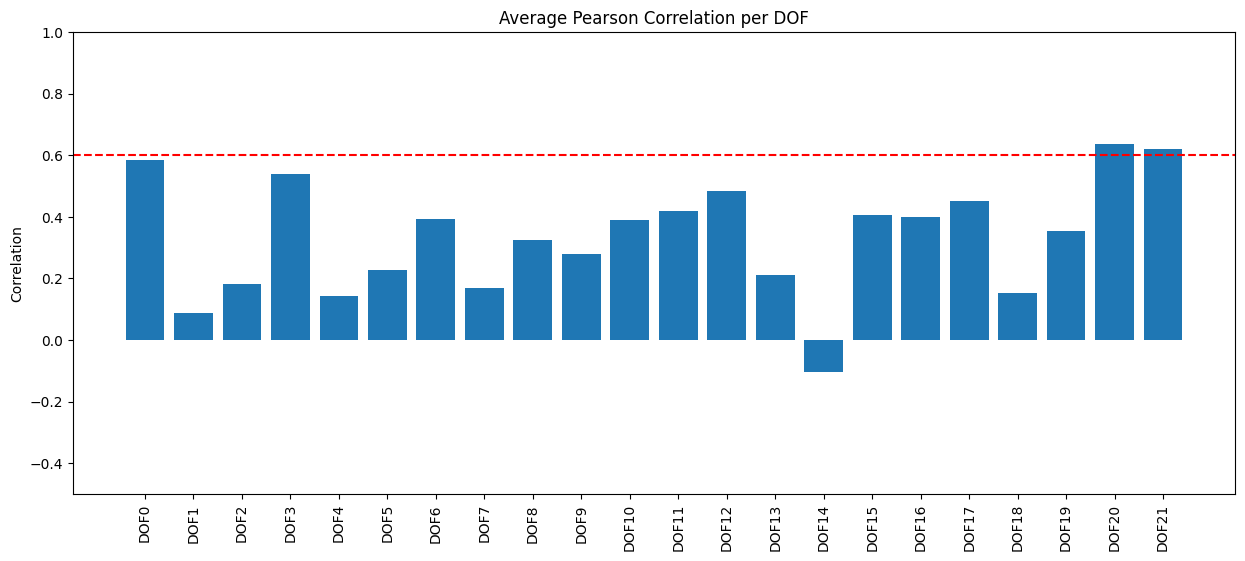


=== Testing Subject 11 ===
Epoch 0, Validation Loss: 0.1685
Epoch 1, Validation Loss: 0.1675
Epoch 2, Validation Loss: 0.1663
Epoch 3, Validation Loss: 0.1656
Epoch 4, Validation Loss: 0.1656
Epoch 5, Validation Loss: 0.1659
Epoch 6, Validation Loss: 0.1677
Epoch 7, Validation Loss: 0.1685
Epoch 8, Validation Loss: 0.1704
Epoch 9, Validation Loss: 0.1695
Epoch 10, Validation Loss: 0.1697
Epoch 11, Validation Loss: 0.1669
Epoch 12, Validation Loss: 0.1668
Epoch 13, Validation Loss: 0.1676
Epoch 14, Validation Loss: 0.1681
Epoch 15, Validation Loss: 0.1651
Epoch 16, Validation Loss: 0.1643
Epoch 17, Validation Loss: 0.1659
Epoch 18, Validation Loss: 0.1668
Epoch 19, Validation Loss: 0.1638
Epoch 20, Validation Loss: 0.1649
Epoch 21, Validation Loss: 0.1654
Epoch 22, Validation Loss: 0.1679
Epoch 23, Validation Loss: 0.1651
Epoch 24, Validation Loss: 0.1640
Epoch 25, Validation Loss: 0.1638
Epoch 26, Validation Loss: 0.1675
Epoch 27, Validation Loss: 0.1672
Epoch 28, Validation Loss: 0.1

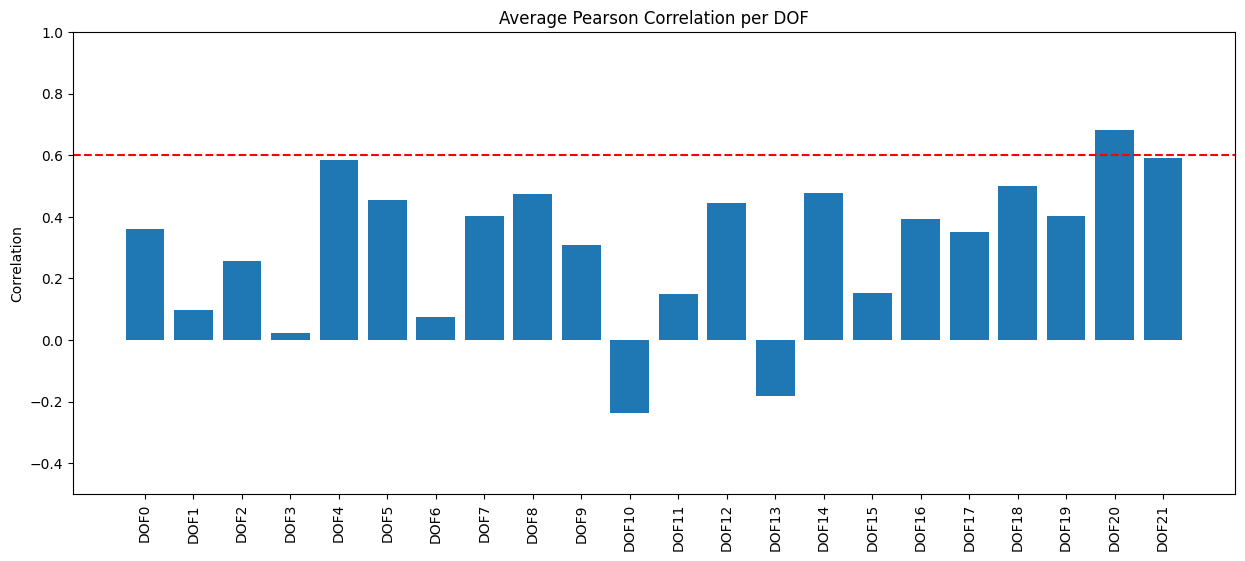


=== Testing Subject 12 ===
Epoch 0, Validation Loss: 0.1641
Epoch 1, Validation Loss: 0.1642
Epoch 2, Validation Loss: 0.1643
Epoch 3, Validation Loss: 0.1640
Epoch 4, Validation Loss: 0.1640
Epoch 5, Validation Loss: 0.1639
Epoch 6, Validation Loss: 0.1649
Epoch 7, Validation Loss: 0.1656
Epoch 8, Validation Loss: 0.1665
Epoch 9, Validation Loss: 0.1655
Epoch 10, Validation Loss: 0.1649
Epoch 11, Validation Loss: 0.1651
Epoch 12, Validation Loss: 0.1653
Epoch 13, Validation Loss: 0.1657
Epoch 14, Validation Loss: 0.1661
Epoch 15, Validation Loss: 0.1669
Epoch 16, Validation Loss: 0.1673
Epoch 17, Validation Loss: 0.1665
Epoch 18, Validation Loss: 0.1652
Epoch 19, Validation Loss: 0.1647
Epoch 20, Validation Loss: 0.1651
Epoch 21, Validation Loss: 0.1658
Epoch 22, Validation Loss: 0.1659
Epoch 23, Validation Loss: 0.1657
Epoch 24, Validation Loss: 0.1655
Epoch 25, Validation Loss: 0.1654
Epoch 26, Validation Loss: 0.1651
Epoch 27, Validation Loss: 0.1649
Epoch 28, Validation Loss: 0.1

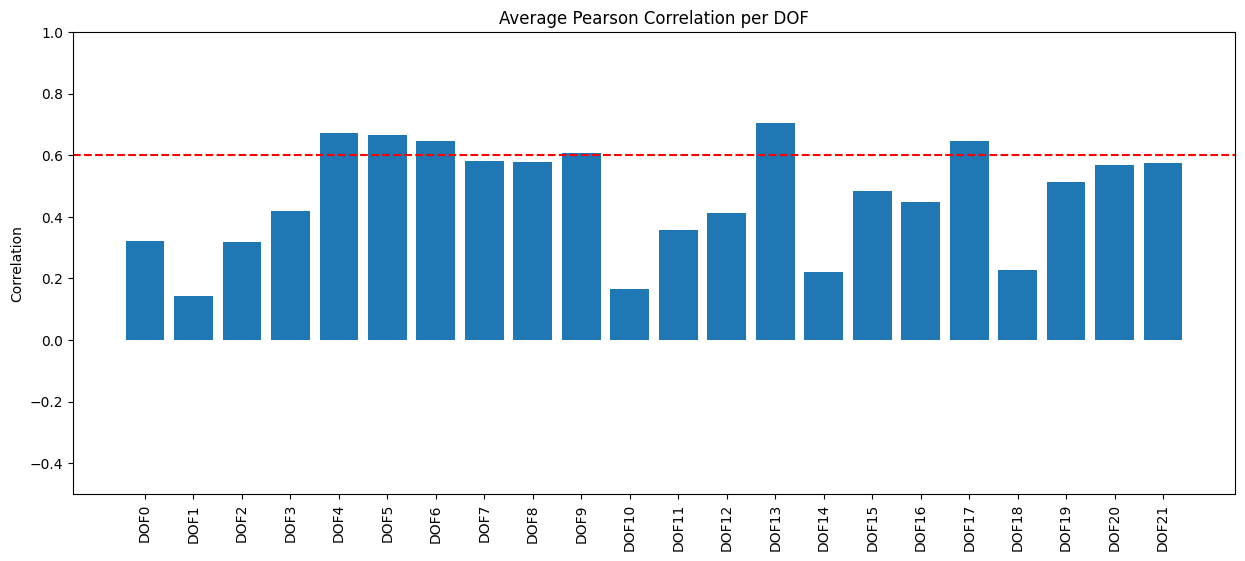


=== Testing Subject 13 ===
Epoch 0, Validation Loss: 0.1660
Epoch 1, Validation Loss: 0.1647
Epoch 2, Validation Loss: 0.1632
Epoch 3, Validation Loss: 0.1621
Epoch 4, Validation Loss: 0.1625
Epoch 5, Validation Loss: 0.1629
Epoch 6, Validation Loss: 0.1634
Epoch 7, Validation Loss: 0.1641
Epoch 8, Validation Loss: 0.1647
Epoch 9, Validation Loss: 0.1657
Epoch 10, Validation Loss: 0.1667
Epoch 11, Validation Loss: 0.1672
Epoch 12, Validation Loss: 0.1671
Epoch 13, Validation Loss: 0.1668
Epoch 14, Validation Loss: 0.1669
Epoch 15, Validation Loss: 0.1666
Epoch 16, Validation Loss: 0.1664
Epoch 17, Validation Loss: 0.1661
Epoch 18, Validation Loss: 0.1656
Epoch 19, Validation Loss: 0.1654
Epoch 20, Validation Loss: 0.1643
Epoch 21, Validation Loss: 0.1645
Epoch 22, Validation Loss: 0.1651
Epoch 23, Validation Loss: 0.1658
Epoch 24, Validation Loss: 0.1662
Epoch 25, Validation Loss: 0.1667
Epoch 26, Validation Loss: 0.1661
Epoch 27, Validation Loss: 0.1654
Epoch 28, Validation Loss: 0.1

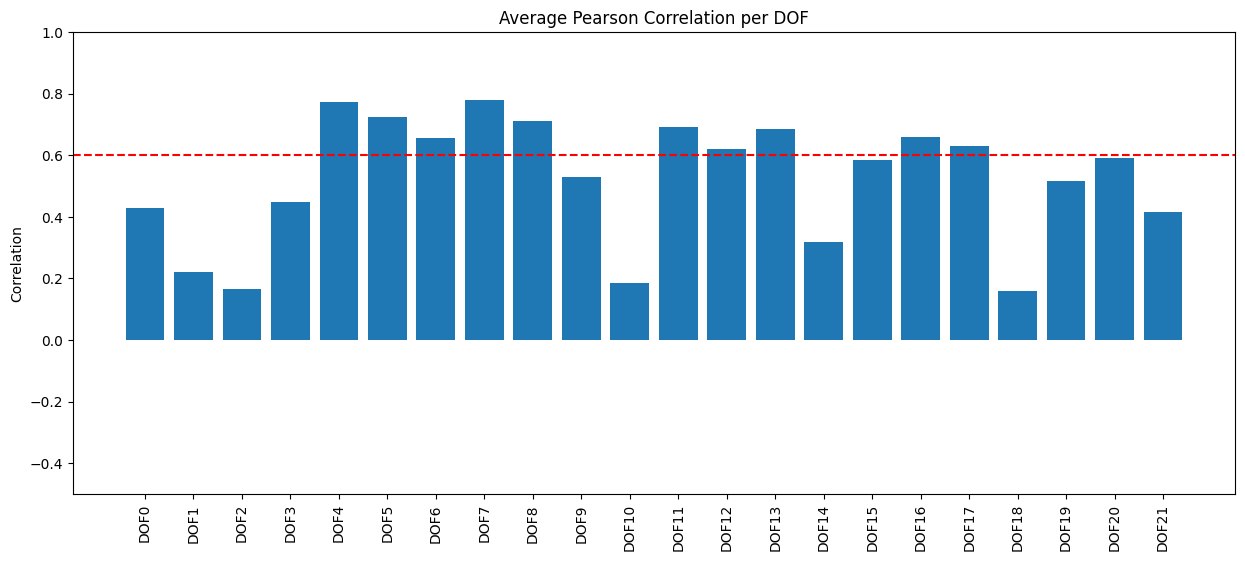


=== Testing Subject 14 ===
Epoch 0, Validation Loss: 0.1621
Epoch 1, Validation Loss: 0.1621
Epoch 2, Validation Loss: 0.1625
Epoch 3, Validation Loss: 0.1630
Epoch 4, Validation Loss: 0.1646
Epoch 5, Validation Loss: 0.1664
Epoch 6, Validation Loss: 0.1676
Epoch 7, Validation Loss: 0.1678
Epoch 8, Validation Loss: 0.1656
Epoch 9, Validation Loss: 0.1636
Epoch 10, Validation Loss: 0.1618
Epoch 11, Validation Loss: 0.1610
Epoch 12, Validation Loss: 0.1622
Epoch 13, Validation Loss: 0.1645
Epoch 14, Validation Loss: 0.1655
Epoch 15, Validation Loss: 0.1651
Epoch 16, Validation Loss: 0.1652
Epoch 17, Validation Loss: 0.1662
Epoch 18, Validation Loss: 0.1645
Epoch 19, Validation Loss: 0.1621
Epoch 20, Validation Loss: 0.1617
Epoch 21, Validation Loss: 0.1644
Epoch 22, Validation Loss: 0.1650
Epoch 23, Validation Loss: 0.1657
Epoch 24, Validation Loss: 0.1649
Epoch 25, Validation Loss: 0.1649
Epoch 26, Validation Loss: 0.1638
Epoch 27, Validation Loss: 0.1610
Epoch 28, Validation Loss: 0.1

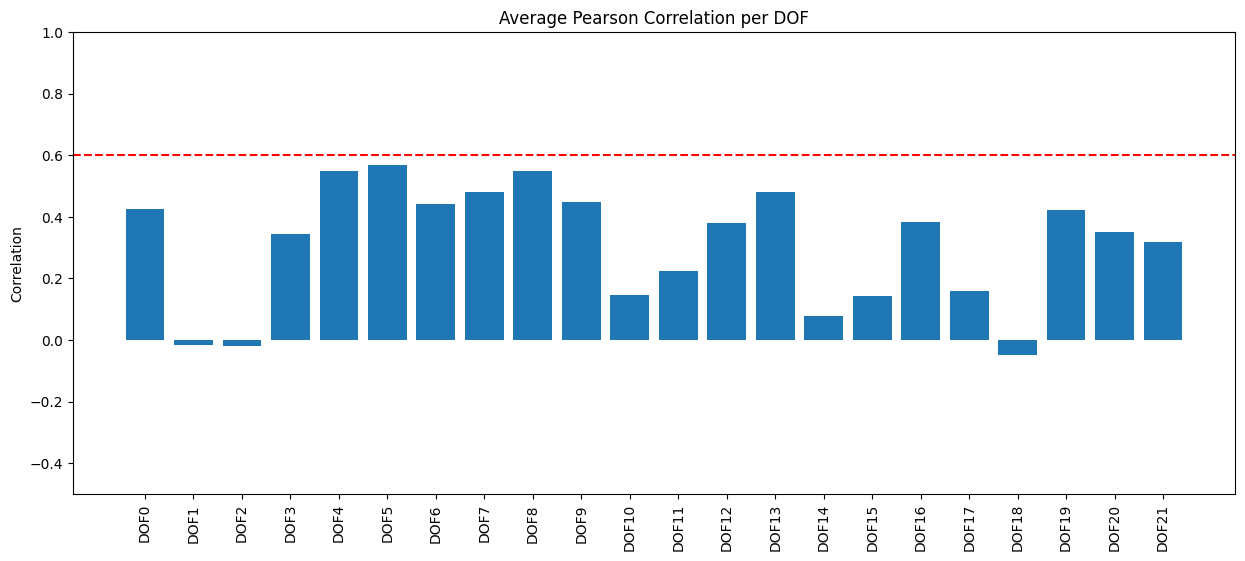


=== Testing Subject 15 ===
Epoch 0, Validation Loss: 0.1615
Epoch 1, Validation Loss: 0.1628
Epoch 2, Validation Loss: 0.1631
Epoch 3, Validation Loss: 0.1626
Epoch 4, Validation Loss: 0.1628
Epoch 5, Validation Loss: 0.1635
Epoch 6, Validation Loss: 0.1627
Epoch 7, Validation Loss: 0.1618
Epoch 8, Validation Loss: 0.1610
Epoch 9, Validation Loss: 0.1603
Epoch 10, Validation Loss: 0.1587
Epoch 11, Validation Loss: 0.1603
Epoch 12, Validation Loss: 0.1615
Epoch 13, Validation Loss: 0.1627
Epoch 14, Validation Loss: 0.1633
Epoch 15, Validation Loss: 0.1615
Epoch 16, Validation Loss: 0.1603
Epoch 17, Validation Loss: 0.1598
Epoch 18, Validation Loss: 0.1602
Epoch 19, Validation Loss: 0.1608
Epoch 20, Validation Loss: 0.1612
Epoch 21, Validation Loss: 0.1624
Epoch 22, Validation Loss: 0.1628
Epoch 23, Validation Loss: 0.1612
Epoch 24, Validation Loss: 0.1608
Epoch 25, Validation Loss: 0.1613
Epoch 26, Validation Loss: 0.1620
Epoch 27, Validation Loss: 0.1621
Epoch 28, Validation Loss: 0.1

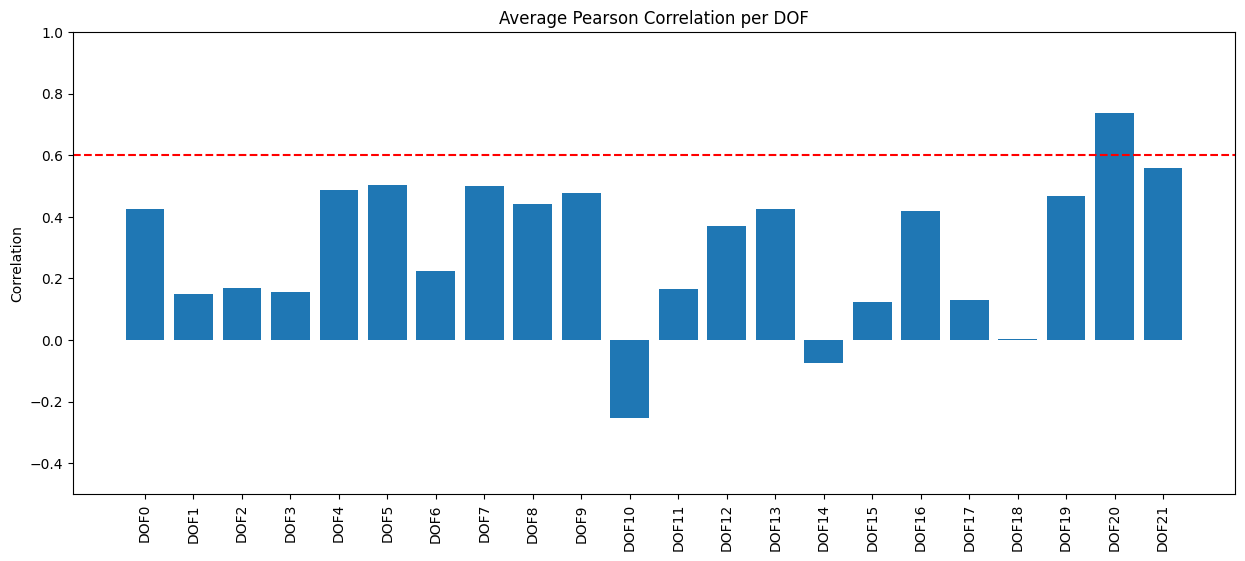


=== Testing Subject 16 ===
Epoch 0, Validation Loss: 0.1613
Epoch 1, Validation Loss: 0.1609
Epoch 2, Validation Loss: 0.1611
Epoch 3, Validation Loss: 0.1612
Epoch 4, Validation Loss: 0.1614
Epoch 5, Validation Loss: 0.1616
Epoch 6, Validation Loss: 0.1613
Epoch 7, Validation Loss: 0.1599
Epoch 8, Validation Loss: 0.1594
Epoch 9, Validation Loss: 0.1601
Epoch 10, Validation Loss: 0.1601
Epoch 11, Validation Loss: 0.1615
Epoch 12, Validation Loss: 0.1628
Epoch 13, Validation Loss: 0.1638
Epoch 14, Validation Loss: 0.1610
Epoch 15, Validation Loss: 0.1578
Epoch 16, Validation Loss: 0.1553
Epoch 17, Validation Loss: 0.1530
Epoch 18, Validation Loss: 0.1542
Epoch 19, Validation Loss: 0.1551
Epoch 20, Validation Loss: 0.1584
Epoch 21, Validation Loss: 0.1620
Epoch 22, Validation Loss: 0.1623
Epoch 23, Validation Loss: 0.1618
Epoch 24, Validation Loss: 0.1601
Epoch 25, Validation Loss: 0.1584
Epoch 26, Validation Loss: 0.1576
Epoch 27, Validation Loss: 0.1583
Epoch 28, Validation Loss: 0.1

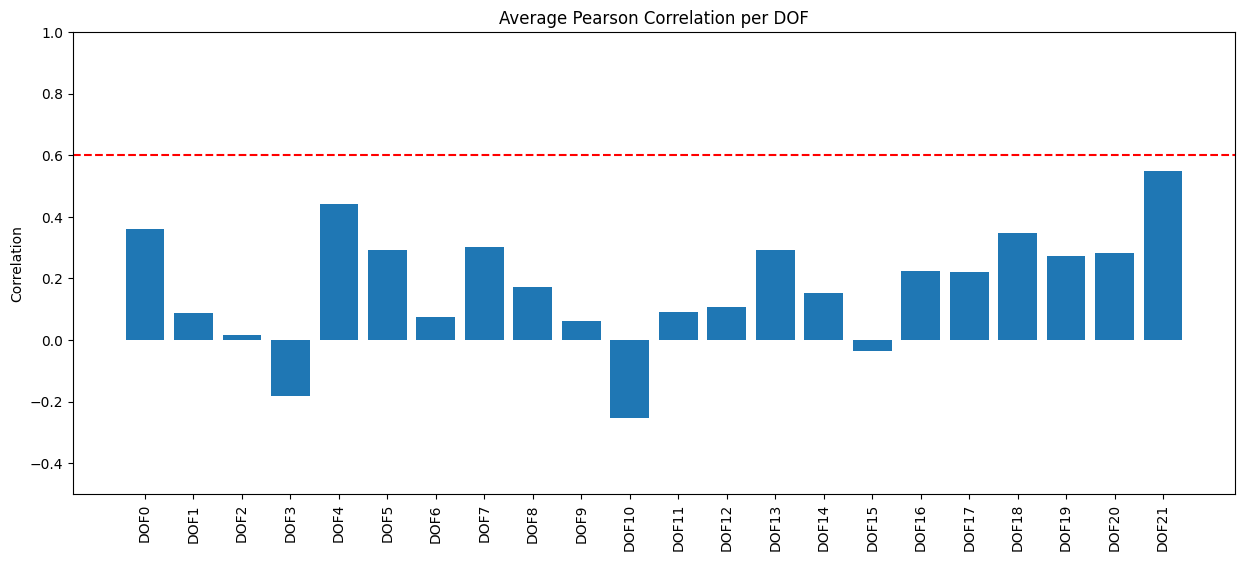


=== Testing Subject 17 ===
Epoch 0, Validation Loss: 0.1639
Epoch 1, Validation Loss: 0.1660
Epoch 2, Validation Loss: 0.1593
Epoch 3, Validation Loss: 0.1565
Epoch 4, Validation Loss: 0.1568
Epoch 5, Validation Loss: 0.1566
Epoch 6, Validation Loss: 0.1572
Epoch 7, Validation Loss: 0.1580
Epoch 8, Validation Loss: 0.1586
Epoch 9, Validation Loss: 0.1593
Epoch 10, Validation Loss: 0.1592
Epoch 11, Validation Loss: 0.1585
Epoch 12, Validation Loss: 0.1575
Epoch 13, Validation Loss: 0.1583
Epoch 14, Validation Loss: 0.1596
Epoch 15, Validation Loss: 0.1597
Epoch 16, Validation Loss: 0.1597
Epoch 17, Validation Loss: 0.1595
Epoch 18, Validation Loss: 0.1586
Epoch 19, Validation Loss: 0.1585
Epoch 20, Validation Loss: 0.1598
Epoch 21, Validation Loss: 0.1594
Epoch 22, Validation Loss: 0.1594
Epoch 23, Validation Loss: 0.1596
Epoch 24, Validation Loss: 0.1600
Epoch 25, Validation Loss: 0.1586
Epoch 26, Validation Loss: 0.1587
Epoch 27, Validation Loss: 0.1598
Epoch 28, Validation Loss: 0.1

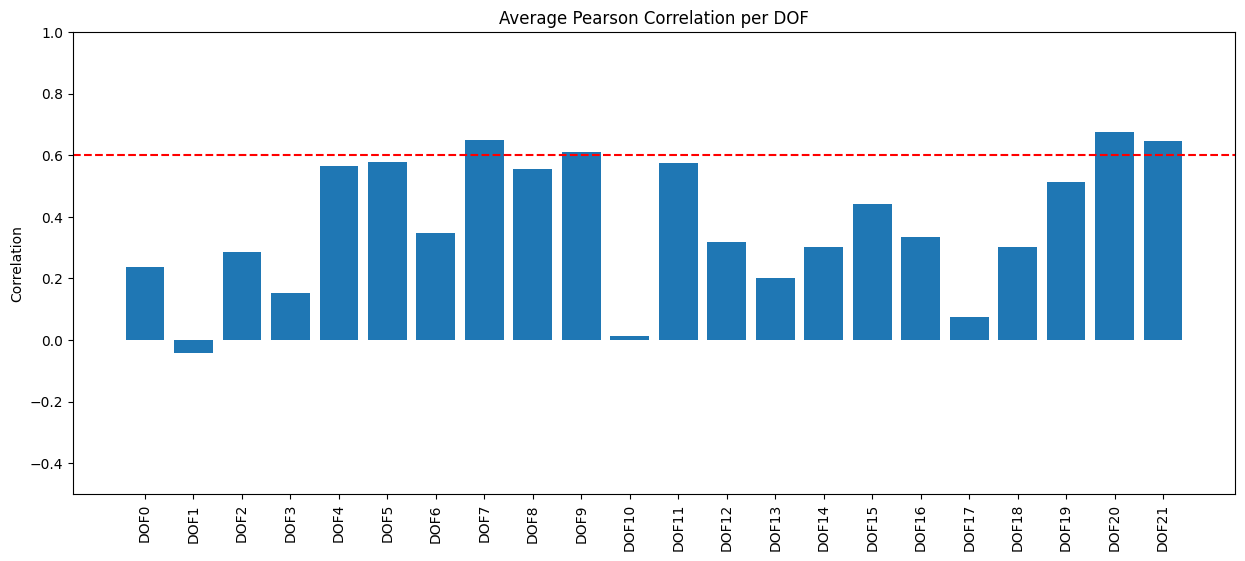


=== Testing Subject 18 ===
Epoch 0, Validation Loss: 0.1578
Epoch 1, Validation Loss: 0.1577
Epoch 2, Validation Loss: 0.1574
Epoch 3, Validation Loss: 0.1577
Epoch 4, Validation Loss: 0.1581
Epoch 5, Validation Loss: 0.1582
Epoch 6, Validation Loss: 0.1582
Epoch 7, Validation Loss: 0.1586
Epoch 8, Validation Loss: 0.1586
Epoch 9, Validation Loss: 0.1588
Epoch 10, Validation Loss: 0.1596
Epoch 11, Validation Loss: 0.1605
Epoch 12, Validation Loss: 0.1616
Epoch 13, Validation Loss: 0.1581
Epoch 14, Validation Loss: 0.1557
Epoch 15, Validation Loss: 0.1562
Epoch 16, Validation Loss: 0.1582
Epoch 17, Validation Loss: 0.1577
Epoch 18, Validation Loss: 0.1573
Epoch 19, Validation Loss: 0.1587
Epoch 20, Validation Loss: 0.1578
Epoch 21, Validation Loss: 0.1573
Epoch 22, Validation Loss: 0.1562
Epoch 23, Validation Loss: 0.1588
Epoch 24, Validation Loss: 0.1594
Epoch 25, Validation Loss: 0.1579
Epoch 26, Validation Loss: 0.1577
Epoch 27, Validation Loss: 0.1588
Epoch 28, Validation Loss: 0.1

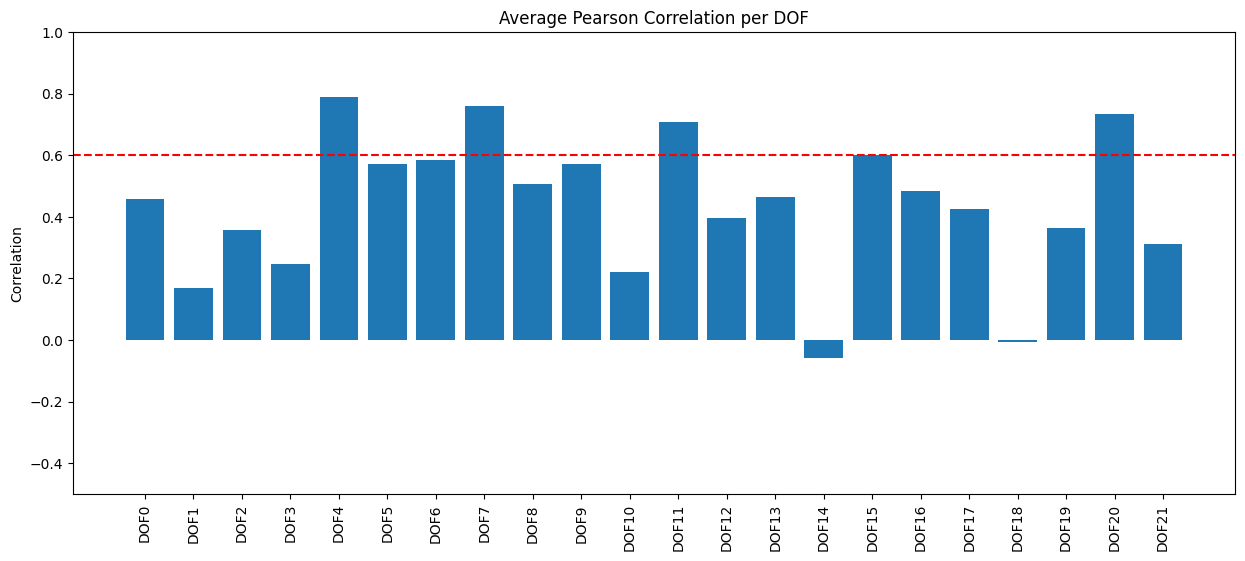


=== Testing Subject 19 ===
Epoch 0, Validation Loss: 0.1568
Epoch 1, Validation Loss: 0.1581
Epoch 2, Validation Loss: 0.1583
Epoch 3, Validation Loss: 0.1580
Epoch 4, Validation Loss: 0.1579
Epoch 5, Validation Loss: 0.1573
Epoch 6, Validation Loss: 0.1565
Epoch 7, Validation Loss: 0.1563
Epoch 8, Validation Loss: 0.1570
Epoch 9, Validation Loss: 0.1568
Epoch 10, Validation Loss: 0.1571
Epoch 11, Validation Loss: 0.1581
Epoch 12, Validation Loss: 0.1600
Epoch 13, Validation Loss: 0.1601
Epoch 14, Validation Loss: 0.1597
Epoch 15, Validation Loss: 0.1588
Epoch 16, Validation Loss: 0.1584
Epoch 17, Validation Loss: 0.1576
Epoch 18, Validation Loss: 0.1561
Epoch 19, Validation Loss: 0.1555
Epoch 20, Validation Loss: 0.1553
Epoch 21, Validation Loss: 0.1548
Epoch 22, Validation Loss: 0.1546
Epoch 23, Validation Loss: 0.1545
Epoch 24, Validation Loss: 0.1554
Epoch 25, Validation Loss: 0.1561
Epoch 26, Validation Loss: 0.1561
Epoch 27, Validation Loss: 0.1556
Epoch 28, Validation Loss: 0.1

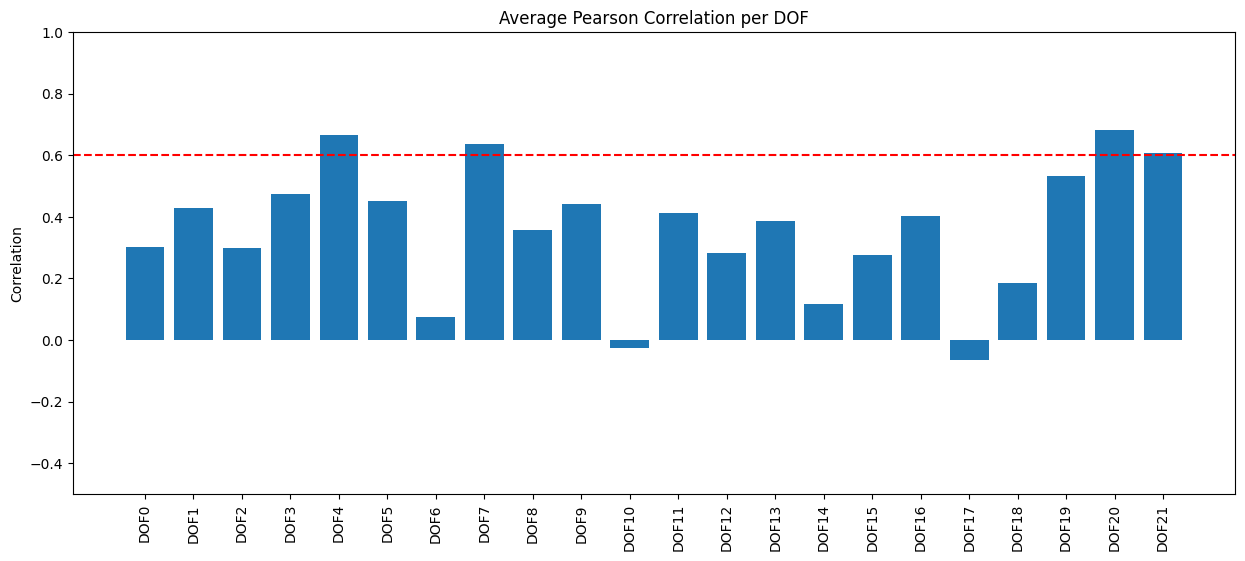


=== Testing Subject 20 ===
Epoch 0, Validation Loss: 0.1567
Epoch 1, Validation Loss: 0.1571
Epoch 2, Validation Loss: 0.1566
Epoch 3, Validation Loss: 0.1567
Epoch 4, Validation Loss: 0.1568
Epoch 5, Validation Loss: 0.1588
Epoch 6, Validation Loss: 0.1593
Epoch 7, Validation Loss: 0.1566
Epoch 8, Validation Loss: 0.1543
Epoch 9, Validation Loss: 0.1533
Epoch 10, Validation Loss: 0.1536
Epoch 11, Validation Loss: 0.1559
Epoch 12, Validation Loss: 0.1576
Epoch 13, Validation Loss: 0.1582
Epoch 14, Validation Loss: 0.1573
Epoch 15, Validation Loss: 0.1556
Epoch 16, Validation Loss: 0.1530
Epoch 17, Validation Loss: 0.1511
Epoch 18, Validation Loss: 0.1500
Epoch 19, Validation Loss: 0.1529
Epoch 20, Validation Loss: 0.1568
Epoch 21, Validation Loss: 0.1586
Epoch 22, Validation Loss: 0.1591
Epoch 23, Validation Loss: 0.1575
Epoch 24, Validation Loss: 0.1555
Epoch 25, Validation Loss: 0.1535
Epoch 26, Validation Loss: 0.1538
Epoch 27, Validation Loss: 0.1555
Epoch 28, Validation Loss: 0.1

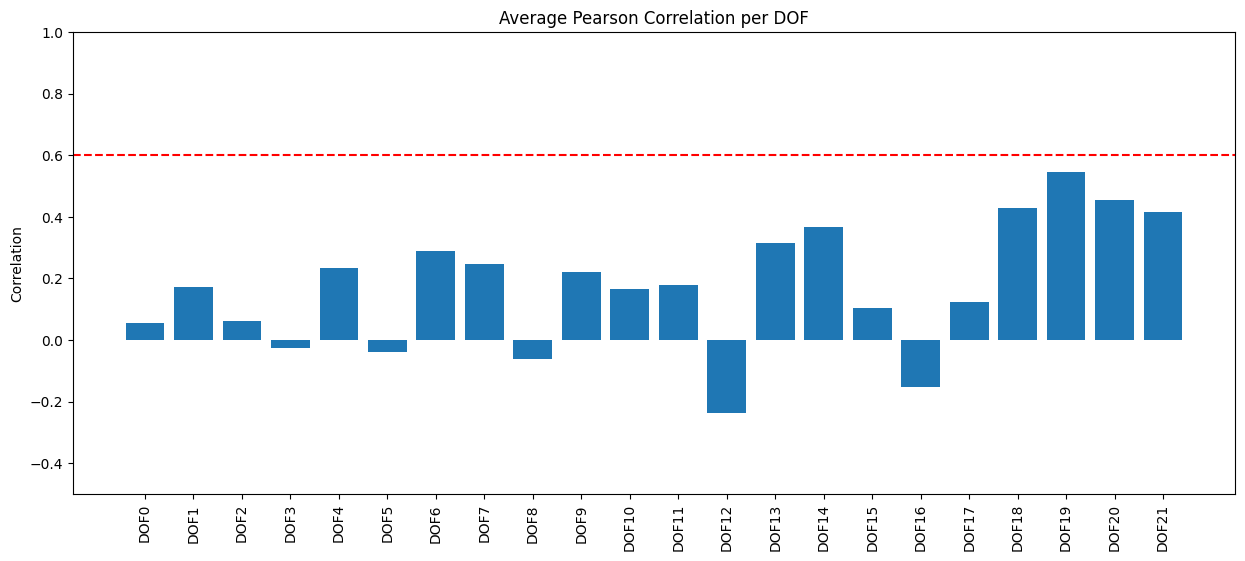


=== Testing Subject 21 ===
Epoch 0, Validation Loss: 0.1550
Epoch 1, Validation Loss: 0.1539
Epoch 2, Validation Loss: 0.1540
Epoch 3, Validation Loss: 0.1552
Epoch 4, Validation Loss: 0.1564
Epoch 5, Validation Loss: 0.1559
Epoch 6, Validation Loss: 0.1553
Epoch 7, Validation Loss: 0.1555
Epoch 8, Validation Loss: 0.1561
Epoch 9, Validation Loss: 0.1558
Epoch 10, Validation Loss: 0.1550
Epoch 11, Validation Loss: 0.1547
Epoch 12, Validation Loss: 0.1554
Epoch 13, Validation Loss: 0.1541
Epoch 14, Validation Loss: 0.1535
Epoch 15, Validation Loss: 0.1530
Epoch 16, Validation Loss: 0.1526
Epoch 17, Validation Loss: 0.1523
Epoch 18, Validation Loss: 0.1529
Epoch 19, Validation Loss: 0.1538
Epoch 20, Validation Loss: 0.1551
Epoch 21, Validation Loss: 0.1544
Epoch 22, Validation Loss: 0.1543
Epoch 23, Validation Loss: 0.1547
Epoch 24, Validation Loss: 0.1557
Epoch 25, Validation Loss: 0.1561
Epoch 26, Validation Loss: 0.1551
Epoch 27, Validation Loss: 0.1538
Epoch 28, Validation Loss: 0.1

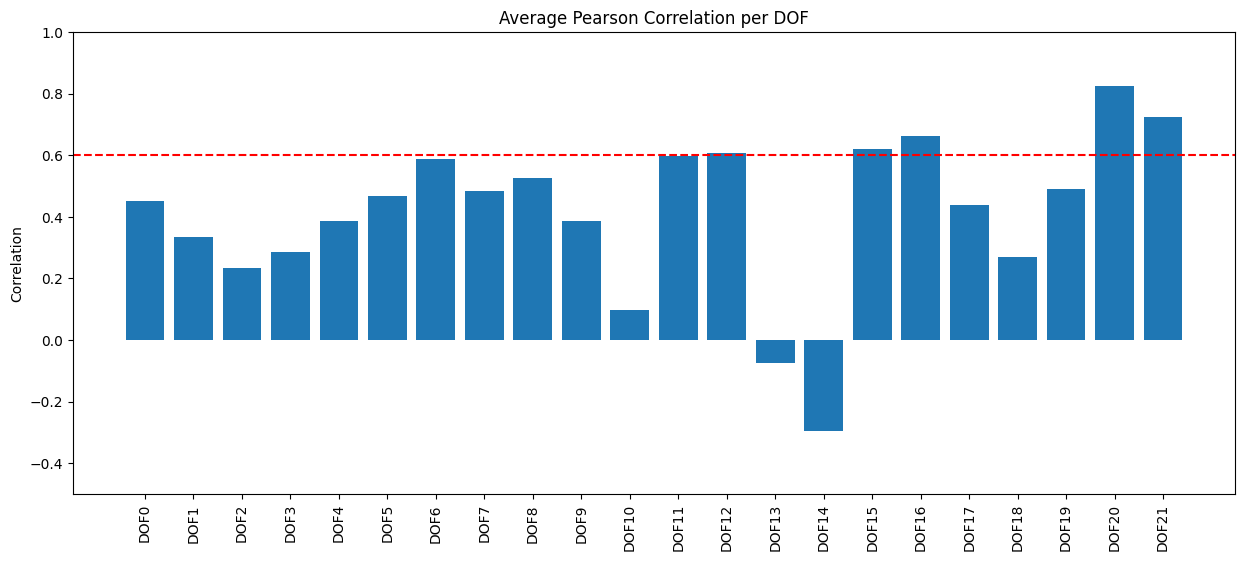


=== Testing Subject 22 ===
Epoch 0, Validation Loss: 0.1521
Epoch 1, Validation Loss: 0.1524
Epoch 2, Validation Loss: 0.1526


In [ ]:
from scipy.stats import pearsonr
import random

if __name__ == "__main__":

    model = MAMLModel()
    model(tf.zeros([1, SEQ_LENGTH, TOTAL_FEATURES]))  # Finalize initialization


    trainer = MAMLTrainer(model)
    dataset = MAMLDataset(base_path='/content/drive/My Drive/Colab Notebooks/dataset wstimi/8 Features', subjects=range(1, 41))
    evaluator = DOFEvaluator()

    all_subjects = list(range(1, 41))  # Subjects 1 to 40
    start_subject = 5

    for test_subject in all_subjects:
        # Skip subjects that were already processed
        if test_subject < start_subject:
            continue  # Skip to the starting subject

        print(f"\n=== Testing Subject {test_subject} ===")

        # Prepare data with strict test isolation
        tasks = dataset.prepare_tasks(test_subject)
        test_seq, test_lab = dataset.load_test_subject(test_subject)

        if not tasks:
            print("No valid tasks, skipping subject")
            continue



        for epoch in range(100):
          meta_batch = random.sample(tasks, min(MAML_BATCH_SIZE, len(tasks)))
          trainer.meta_step(meta_batch)
          val_loss = evaluate_on_val(tasks)
          print(f"Epoch {epoch}, Validation Loss: {val_loss:.4f}")


        # Final evaluation (no fine-tuning on test data!)
        test_pred = model.predict(test_seq)
        pearson_scores = [pearsonr(test_lab[:,i], test_pred[:,i])[0]
                         for i in range(DOF_COUNT)]
        evaluator.update_metrics(test_lab, test_pred)

        print(f"Subject {test_subject} Results:")
        print (pearson_scores)

        print(f"Subject {test_subject} - Avg Correlation: {np.mean(pearson_scores):.2f}")
        savedata(test_subject, pearson_scores)

        dofevaluator = DOFEvaluator()
        dofevaluator.update_metrics(test_lab, test_pred)
        dofevaluator.plot_results()
